<a href="https://colab.research.google.com/github/redwineyards/autoencoders/blob/main/resnet_autoencoder/resnet_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(torch.cuda.is_available())
seed=42
torch.manual_seed(seed)
if device=='cuda': torch.cuda.manual_seed_all(seed)

root="/content/data"
trans=transforms.Compose([transforms.ToTensor()])
training_set=torchvision.datasets.MNIST(root=root,train=True,transform=trans,download=True)
test_set=torchvision.datasets.MNIST(root=root, train=False,transform=trans, download=True)

True



Extracting /content/data/MNIST/raw/train-images-idx3-ubyte.gz to /content/data/MNIST/raw




Extracting /content/data/MNIST/raw/train-labels-idx1-ubyte.gz to /content/data/MNIST/raw




Extracting /content/data/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/data/MNIST/raw




Extracting /content/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/data/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [2]:
num_epochs=20
learning_rate=1e-3
batch_size=1024
train_loader=torch.utils.data.DataLoader(training_set,batch_size=batch_size,shuffle=True)
test_loader=torch.utils.data.DataLoader(test_set,batch_size=batch_size,shuffle=False)

In [18]:
class EncResBlock(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size, stride,padding=(0,0,0)):
    super(EncResBlock,self).__init__()
    self.subblock_1=nn.Sequential(
        nn.Conv2d(in_channels[0],out_channels[0], kernel_size[0], stride[0],padding[0]),
        nn.BatchNorm2d(out_channels[0]),
        nn.ReLU()
    )
    self.subblock_2=nn.Sequential(
        nn.Conv2d(in_channels[1], out_channels[1], kernel_size[1], stride[1], padding[1]),
        nn.BatchNorm2d(out_channels[1])
    )
    self.skip=nn.Sequential(
        nn.Conv2d(in_channels[2],out_channels[2],kernel_size[2],stride[2], padding[2],bias=False)
    )
  def forward(self,x):
    residue=self.skip(x)
    out=self.subblock_1(x)
    out=self.subblock_2(out)+residue
    return F.relu(out).to(device)

In [19]:
class DecResBlock(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size,stride,padding=(0,0,0)):
    super(DecResBlock,self).__init__()
    self.subblock_1=nn.Sequential(
        nn.ConvTranspose2d(in_channels[0],out_channels[0], kernel_size[0], stride[0],padding[0]),
        nn.BatchNorm2d(out_channels[0]),
        nn.ReLU()
    )
    self.subblock_2=nn.Sequential(
        nn.ConvTranspose2d(in_channels[1], out_channels[1], kernel_size[1], stride[1],padding[1]),
        nn.BatchNorm2d(out_channels[1])
    )
    self.skip=nn.Sequential(
        nn.ConvTranspose2d(in_channels[2],out_channels[2],kernel_size[2],stride[2],padding[2],bias=False)
    )
  
  def forward(self,x):
    residue=self.skip(x)
    out=self.subblock_1(x)
    out=self.subblock_2(out)+residue
    return F.relu(out).to(device)

In [38]:
class ResNet(nn.Module):
  def __init__(self):
    super(ResNet,self).__init__()
    self.enc1=EncResBlock((1,16,1),(16,32,32),(9,7,1),(1,1,2))
    self.enc2=EncResBlock((32,32,32),(32,32,32),(5,3,1),(1,1,2),(0,0,1))
    self.enc3=EncResBlock((32,32,32),(32,64,64),(3,3,1),(1,1,2))
    self.enc4=EncResBlock((64,64,64),(64,64,64),(3,2,4),(1,1,1))
    
    self.dec1=DecResBlock((64,64,64),(64,64,64),(2,3,4),(1,1,1))
    self.dec2=DecResBlock((64,32,64),(32,32,32),(3,3,2),(1,1,2))
    self.dec3=DecResBlock((32,32,32),(32,32,32),(3,5,2),(1,1,2),(0,0,1))
    self.dec4=DecResBlock((32,16,32),(16,1,1),(7,9,2),(1,1,2))

  def forward(self,x):
    out=self.enc1(x)
    out=self.enc2(out)
    out=self.enc3(out)
    out=self.enc4(out)
    out=self.dec1(out)
    out=self.dec2(out)
    out=self.dec3(out)
    out=self.dec4(out)
    out=torch.sigmoid(out)
    return out

In [39]:
def train(model,train_loader,num_epochs,learning_rate):
  losses=[]
  optimizer=torch.optim.Adam(model.parameters(), lr=learning_rate)
  lossfn=torch.nn.BCELoss().to(device)
  for epoch in range(num_epochs):
    model.train()
    for i,(images,_) in enumerate(train_loader):
      images=images.to(device)
      output=model(images.float())
      loss=lossfn(output,images.float())
      losses.append(loss)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      
    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch + 1, num_epochs,loss.item()))
    tens=[]
    tens_reconstr=[]
    plt.subplots(figsize=(50, 5))
    nos=[1,128,12370,111,2,244,44444,54695,14831,2299]
    for i in range(10):
      model.eval()
      tens.append(training_set[nos[i]][0].reshape(-1,1,28,28))
      #tens1=torch.rand(1,1,28,28)*0.1
      #test1=np.squeeze(tens[i].numpy())
      with torch.no_grad():
        tens_reconstr.append(model.forward(tens[i].to(device)))
        #test_reconstr=np.squeeze(tens_reconstr[i].cpu().numpy())
      #fig, (ax1, ax2) = plt.subplots(1, 2)
      plt.subplot(1,20,2*i+1)
      plt.imshow(np.squeeze(tens[i].numpy()))
      plt.subplot(1,20,2*i+2)
      plt.imshow(np.squeeze(tens_reconstr[i].cpu().numpy()))
    plt.pause(1e-10)
  return losses

In [40]:
def evaluate(model,test_loader):
  lossfn=torch.nn.BCELoss()
  model.eval()
  with torch.no_grad():
    total=0
    for i,(images,_) in enumerate(test_loader):
      images=images.to(device)
      output=model.forward(images)
      total+=lossfn(output,images.float())
    
    loss=total/len(test_loader)
    print("model test loss on MNIST test set:", loss.item())

Epoch [1/20], Loss: 0.6927


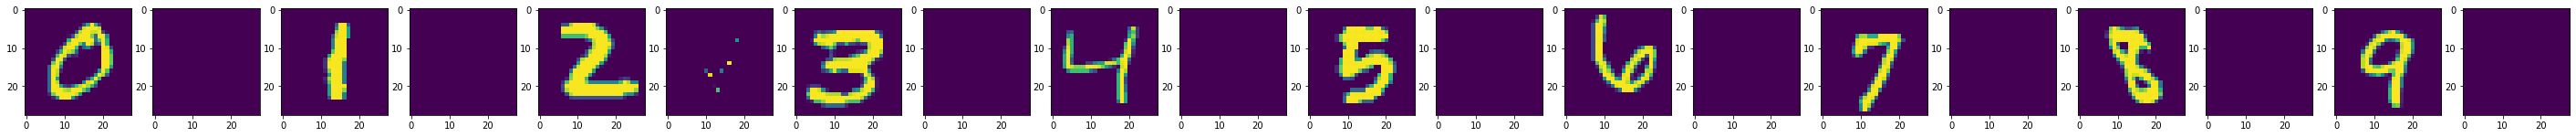

Epoch [2/20], Loss: 0.6918


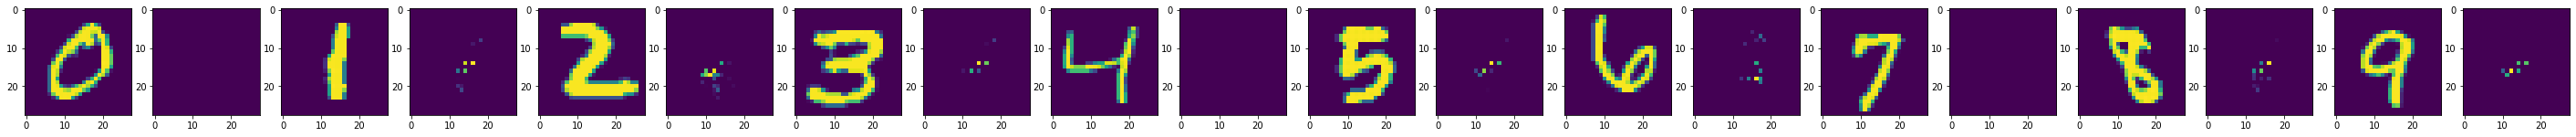

Epoch [3/20], Loss: 0.6817


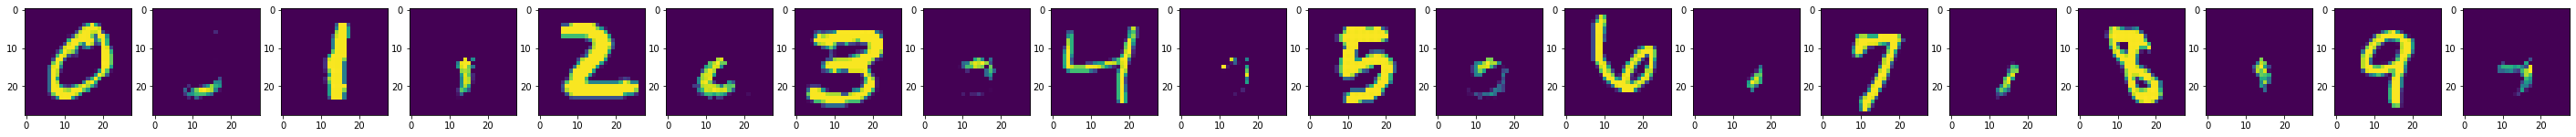

Epoch [4/20], Loss: 0.6728


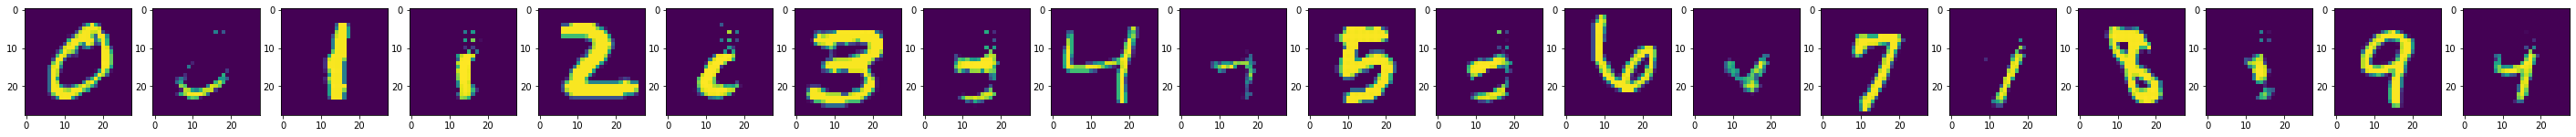

Epoch [5/20], Loss: 0.6642


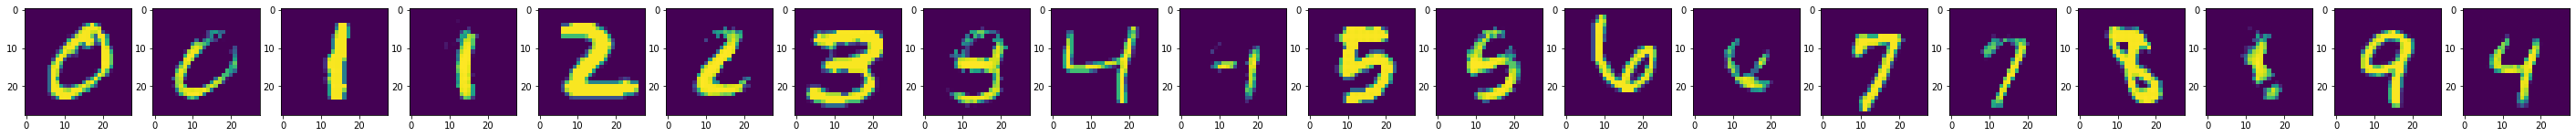

Epoch [6/20], Loss: 0.6563


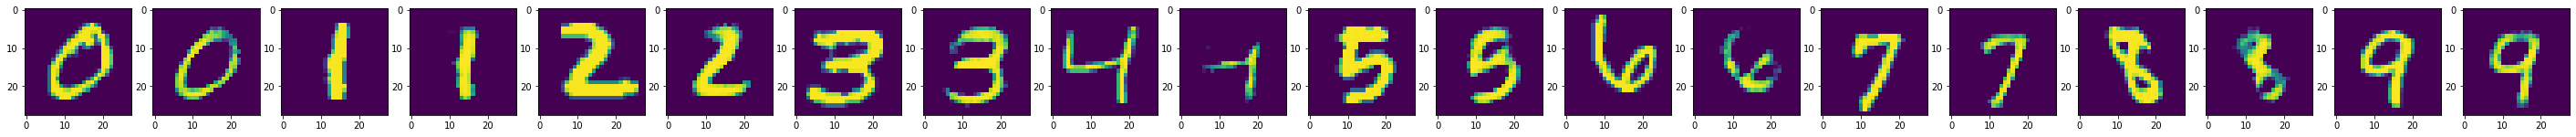

Epoch [7/20], Loss: 0.6491


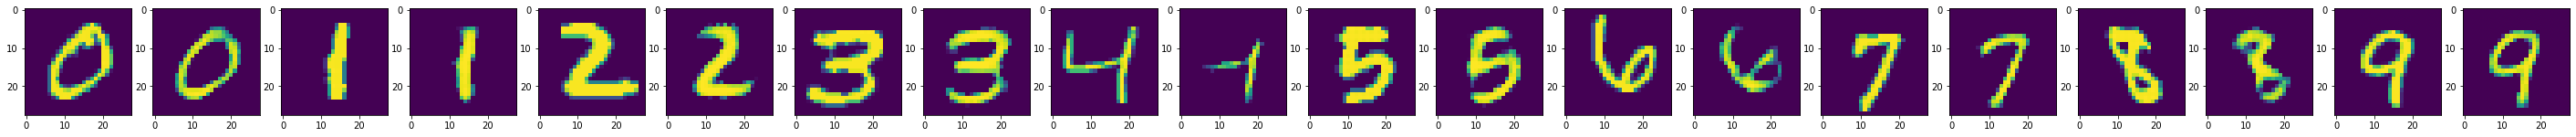

Epoch [8/20], Loss: 0.6481


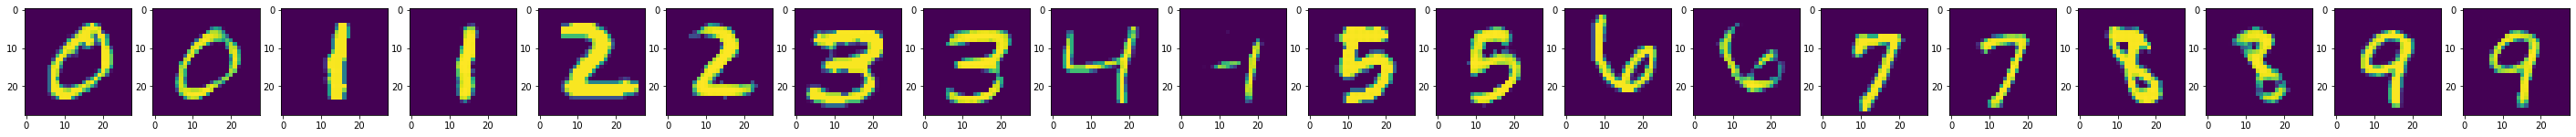

Epoch [9/20], Loss: 0.6454


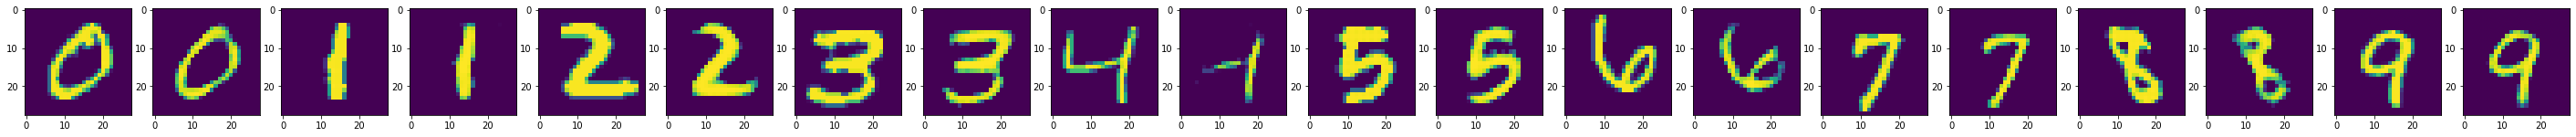

Epoch [10/20], Loss: 0.6460


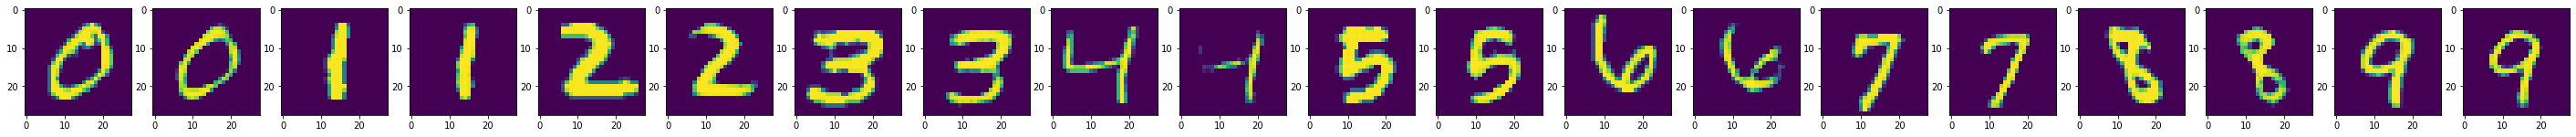

Epoch [11/20], Loss: 0.6436


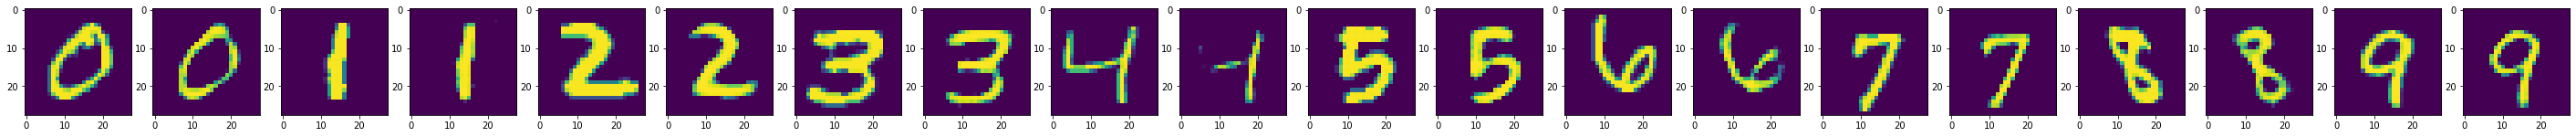

Epoch [12/20], Loss: 0.6439


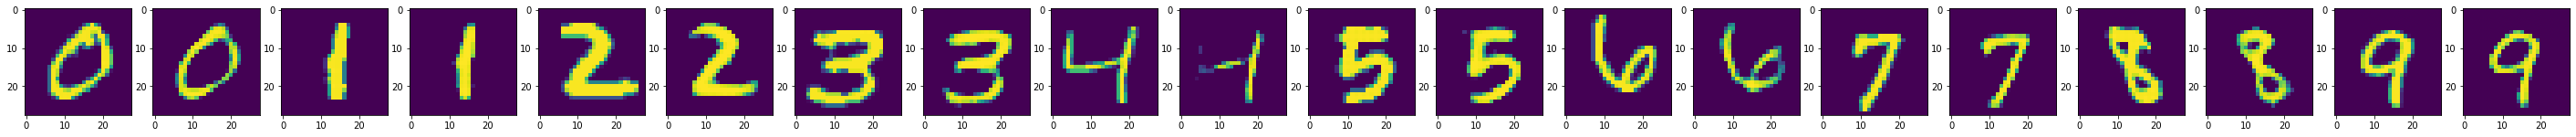

Epoch [13/20], Loss: 0.6438


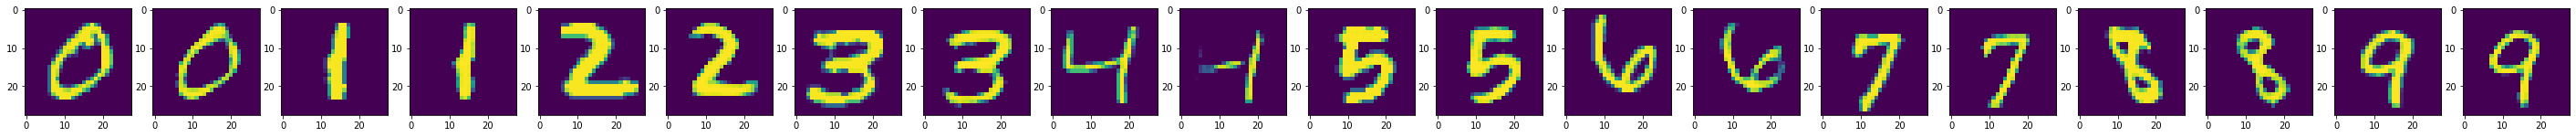

Epoch [14/20], Loss: 0.6425


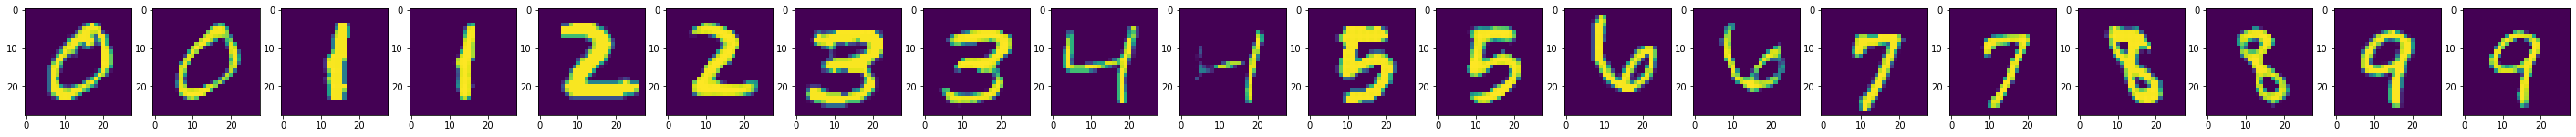

Epoch [15/20], Loss: 0.6410


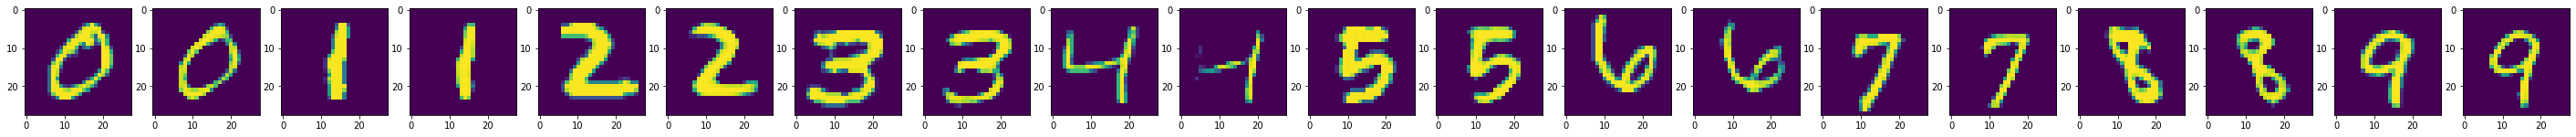

Epoch [16/20], Loss: 0.6420


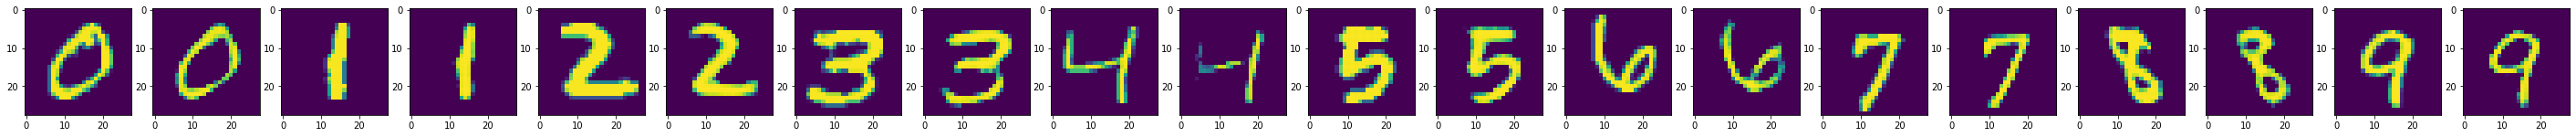

Epoch [17/20], Loss: 0.6399


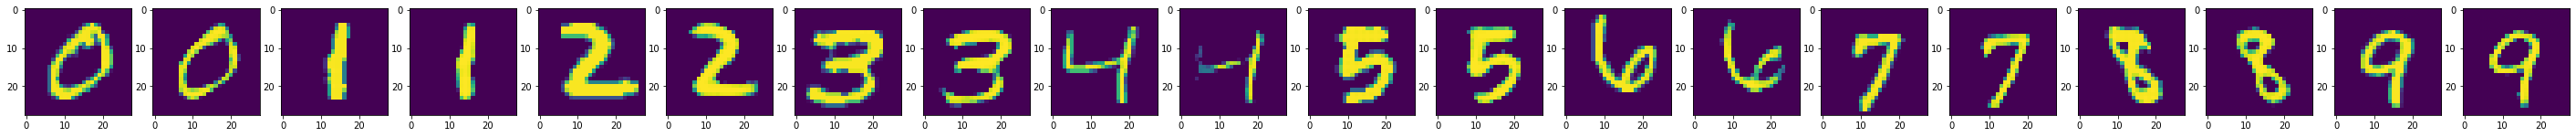

Epoch [18/20], Loss: 0.6408


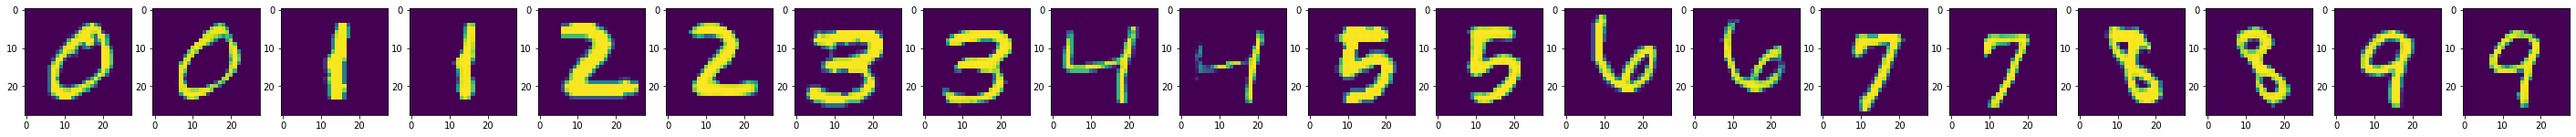

Epoch [19/20], Loss: 0.6397


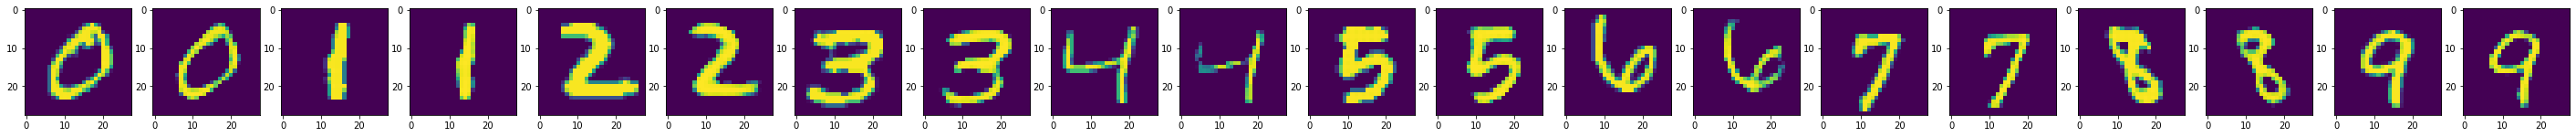

Epoch [20/20], Loss: 0.6388


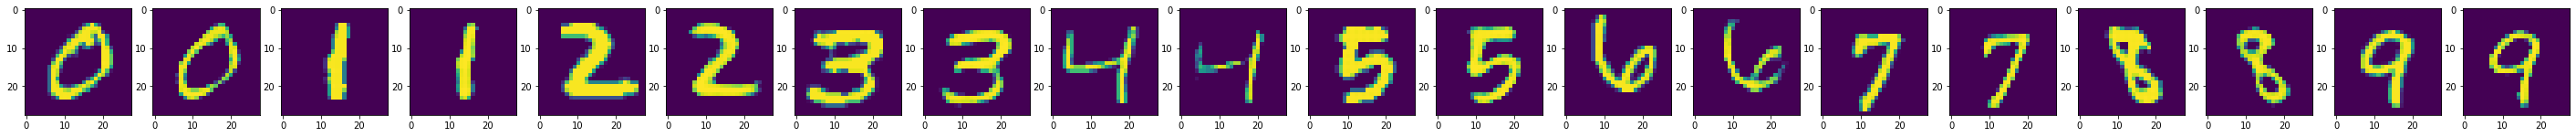

In [41]:
model=ResNet().to(device)
losses=train(model,train_loader,num_epochs,learning_rate)

In [ ]:
losses=train(model,train_loader,num_epochs,learning_rate=1e-4)

In [43]:
evaluate(model,test_loader)

model test loss on MNIST test set: 0.6380707621574402
